# Hybrid Models

There are generally 2 ways a regression algorithm can make predictions, either by feature based transforms, or target based transforms.<br>
- Feature-transforming algorithms learn a transform that allow them to predict the target using some weighted combination of the input features. Linear regression and neural nets are of this kind.<br>
- Target-transforming algorithms group the input features in the training set and generate a prediction based on the average of the groups target values. Decision trees and nearest neighbors are of this kind.

A strength of linear regression is that it can extrapolate new values.  So it's great at following a trend even if it has never seen particular input values. A weakness is that it's an averaging algorithm, it's not good at accurately forcasting data that falls off it's hyperplane.<br>
A strength of decision tree based algorithms is that they are particularly good at accurately forcasting data. A weakness is their predictions are bound by the averages found withen the original training set.  So they cannot extrapolate trend beyond what they have seen during training.<br>

To utilize the strengths of both algorithms (and in the process minimize each weakness)<br>
   1. Use linear regression to detrend data
   2. Use a decision tree based algorithm to make predictions on the residuals left over from 1.
   
This can be done using a series of Jupyter notebook cells, but it's a bit more foolproof if we wrap these 2 algorithms in an object with a scikitlearn type of interface

See <a href="https://www.kaggle.com/code/ryanholbrook/hybrid-models">Hybrid Models</a> for original Kaggle lesson.<br>
See <a href="https://www.kaggle.com/code/kperkins411/time-series-bonus-lesson-unofficial/edit">Time Series Bonus Lesson (Unofficial)</a> for additional hybrid model insights

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)
    

# Data
Use the tunnel dataset from <a href="https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data">Kaggle</a>.   It tracks the number of cars traveling through through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005

In [2]:
#read data convert the Day dolumn to pandas datetime
df = pd.read_csv("../datasets/kaggle/tunnel.csv", parse_dates=["Day"])

#day is really date, change column name
df=df.rename(columns={"Day": "Date"})

df=df.set_index("Date")

#set a time index (just an integer from 0 to len dataframe)
df['Time']=np.arange(len(df))
len(df)

747

# Lags

## Are lags predictive?

/home/keith/anaconda3/envs/data301/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/keith/anaconda3/envs/data301/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


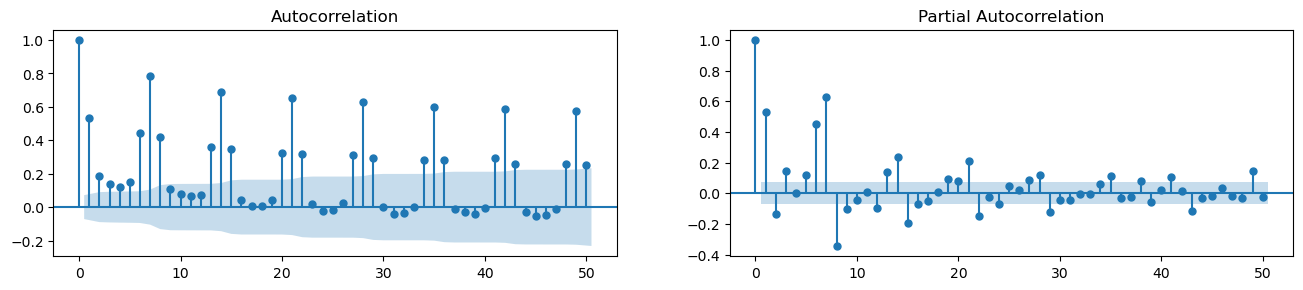

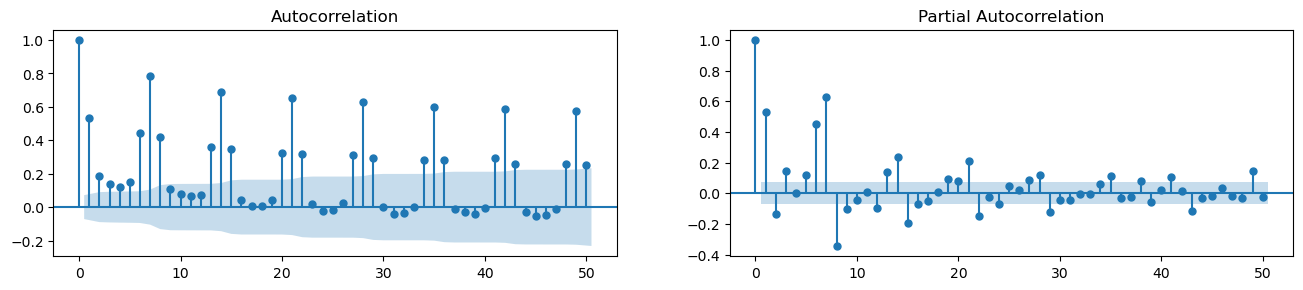

In [3]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.NumVehicles.tolist(), lags=50, ax=axes[0])
plot_pacf(df.NumVehicles.tolist(), lags=50, ax=axes[1])

## Yes, add them to the dataframe
These plots show that past values are predictive of future values, so add them to the dataset
can do 7 or 14 or 21, start with 7

# Feature Engineering

## Holidays seem to have an effect on tunnel traffic, add a holiday variable to indicate whether its a holiday or not

### Create a calander to track local holidays

In [4]:
# create a calander of swiss holidays to mark in the dataset
#see https://sodocumentation.net/pandas/topic/7976/holiday-calendars
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, Easter
from pandas.tseries.offsets import Day, CustomBusinessDay

#You can do this for any nationality, find all the holidays and create a Holiday calendar
class SwissHolidayCalendar(AbstractHolidayCalendar):
    """ Custom Holiday calendar for Swiss
      - 1 January: New Year's Day
      - Moveable Ascension Day (Thursday, 39 days after Easter Sunday)
      - 1 August: National Day
      - 25 December: Christmas Day
    """
    rules = [
        Holiday('New Years Day', month=1, day=1),
        Holiday('Ascension Day', month=1, day=1, offset=[Easter(), Day(39)]),  #notice that this is 39 days after easter of the year in question
        Holiday('National Day', month=8, day=1),
        Holiday('Christmas Day', month=12, day=25)
    ]
    
# want US holidays?  There is a package for that that operates like the custom calendar above
# from pandas.tseries.holiday import USFederalHolidayCalendar
# cal = USFederalHolidayCalendar()

In [5]:
# Creating a custom calendar
cal = SwissHolidayCalendar()

#Find all holidays in the tunnel traffic time series
hols=cal.holidays(start=str(df.index[0]), end=str(df.index[len(df)-1]))
hols

DatetimeIndex(['2003-12-25', '2004-01-01', '2004-05-20', '2004-08-01',
               '2004-12-25', '2005-01-01', '2005-05-05', '2005-08-01'],
              dtype='datetime64[ns]', freq=None)

### Add swiss holidays to dataframe

In [6]:
def add_holidays(df,hols):
    '''
    adds a holiday column to df with a 1 if day is a holiday, 0 otherwise
    returns modified df
    '''
    df['Holiday'] = df.index.isin(hols).astype(int)
    return df
df=add_holidays(df,hols)
# df[50:60]

### Travel days around a holiday are probably important as well

In [7]:
#do people travel 2 or 3 days before holiday?
#add another column which indicates travel days around holiday (default to 1 before and 1 after?)
def add_holiday_travel_days(df,hols, numb_days=1):
    '''
    adds 'Holiday_travel_day' column to df with a 1 if withen x days of holiday, 0 otherwise
    df
    hols: holidays
    numb_days: numb days around holiday to add
    returns modified df
    '''
    df['Holiday_travel_day']=0
    for hol in hols:
        for i in range(1,numb_days+1):
            df.loc[hol- pd.DateOffset(days=i),'Holiday_travel_day']=1
            df.loc[hol+ pd.DateOffset(days=i),'Holiday_travel_day']=1
    return df

#mark travel days around holidays
df=add_holiday_travel_days(df,hols,2)

#shows Christmas and new years
# df[40:60]

## It's helpful to know if it's a workday or a weekend, so add a column that indicates that

In [8]:
## maybe mark whether its a workday or a weekend?  This information is probably encoded in the lags already
#is it a workday or weekend
df['wd'] = 1  #its a workday
df.loc[df.index.dayofweek > 4, 'wd'] = 0  # >4 is weekend

# The hybrid Model

Predicts travel for the next day based on the current date, previous n lag values and holiday and holiday_travel_day values. 
The model has 2 methods:<br>
fit:
1. Fit a linear regressor (model_1) to a train set
2. Calculate predictions (preds) on train set
3. Calculate residuals (target-preds) to detrend the train set
4. Fit catboost (model_2) on train set residuals 

predict:
1. model_1.predict + model_2.predict

Their are some problems however, the first is the lags, when predicting we have to have a list of n previous residuals. This means that the start of test set will be missing the end of the training sets lag values unless they are saved somehow.<br>
The second problem is that the model_2 depends on the residulas calculated by the first model for the lags. Specifically model_2 works on the detrended data, these have to be calculated and saved, which means the model has to see the test data to calculate the lags.  This is not a problem in terms of leakage, it just makes keeping track of data and ensuring the model does not accidentally 'see' future or current data that much harder.


In [73]:
class BoostedHybrid:
    '''
    Runs model_1 on data, then runs model_2 on residuals of model_1
    In practice model_1 detrends the data then model_2 uses a ML algorithm to forcast target values on detrended data
    '''
    def __init__(self, model_1, model_2, num_lags=0):
        self.model_1 = model_1
        self.model_2 = model_2
        self.num_lags=num_lags

    def fit(self, X_1,X_2, y, train_size=0.9 ):
        '''
        X_1 entire dataset for linear regression(uses column 'Time')
        X_2 entire dataset for GBT ('all other dataset columns')
        y  target ('NumVehicles')
        train_size: the fraction of the begginning of X_1 and X_2 to be used for training, the rest for test
        CAREFUL HERE TO NOT ACCIDENTALLY TRAIN ON TEST SET
        '''
        self.train_size=int(len(X_1)*train_size)
        self.test_size=len(X_1)-self.train_size
        X_1=X_1.copy()
        X_2=X_2.copy()
        
        #fit the first model on train portion of dataset
        self.model_1.fit(X_1.iloc[0:self.train_size,:], y[:self.train_size]) # train model 1
        
        #generate residuals for entire dataset (only used to calculate lags)
        self.y_resid = y - self.model_1.predict(X_1)
        
        #compute and add the lags to X_2
        X_2['y_resid']=self.y_resid
        for i in range(1,self.num_lags+1):
            X_2['Lag_'+str(i)]=X_2.y_resid.shift(i)
        # display(X_2)   
        X_2.dropna(inplace=True)  #alas goodbye to some rows

        #save these residuals for later
        self.y_resid=X_2.y_resid
        
        #drop target from training data
        X_2.drop(columns=['y_resid'],inplace=True, axis=1)  #this gets rid of target value, so model only sees past lags
        # display(X_2)
        
        #fit the second model on residuals from first model, just the train data part
        # print(f'X_2.iloc[0:self.train_size,:].shape={X_2.iloc[0:self.train_size,:].shape}')
        self.model_2.fit(X_2.iloc[0:self.train_size,:], self.y_resid[:self.train_size])
        self.X_1=X_1
        self.X_2=X_2
        
    def predict(self):
        #to get a prediction add Model_1's prediction to Model_2's prediction
        X_1=self.X_1.iloc[-self.test_size:,:]
        # display(X_1)
        y_pred1 = self.model_1.predict(X_1)
        
        X_2=self.X_2.iloc[-self.test_size:,:]
        # display(X_2)
        y_pred2=self.model_2.predict(X_2)
        return(y_pred1+y_pred2)

## Partition dataset

In [74]:
#get our target value, the training set for linear regression, and the training set for catboost
y=df.NumVehicles
X_1=df.loc[:,['Time']]
X_2=df.loc[:,['Time','Holiday','Holiday_travel_day','wd']]
# X_2=df.loc[:,['Time']]
# display(y)
# display(X_1)
# display(X_2)

## Train the model on train set

In [72]:
X_2

,Time,Holiday,Holiday_travel_day,wd
Date,,,,
2003-11-01,0,0,0,0
2003-11-02,1,0,0,0
2003-11-03,2,0,0,1
2003-11-04,3,0,0,1
2003-11-05,4,0,0,1
...,...,...,...,...
2005-11-12,742,0,0,0
2005-11-13,743,0,0,0
2005-11-14,744,0,0,1


In [66]:
from sklearn import linear_model
from catboost import CatBoostRegressor
hm=BoostedHybrid(model_1 = linear_model.LinearRegression(), model_2=CatBoostRegressor(silent=True, random_state=42), num_lags=1)

#fit the model
hm.fit(X_1,X_2,y)

,Time,Holiday,Holiday_travel_day,wd,y_resid,Lag_1
Date,,,,,,
2003-11-01,0,0,0,0,5546.796107,NaN
2003-11-02,1,0,0,0,-5961.482125,5546.796107
2003-11-03,2,0,0,1,2759.239643,-5961.482125
2003-11-04,3,0,0,1,4292.961412,2759.239643
2003-11-05,4,0,0,1,8486.683180,4292.961412
...,...,...,...,...,...,...
2005-11-12,742,0,0,0,-10615.651741,11411.626491
2005-11-13,743,0,0,0,-20860.929972,-10615.651741
2005-11-14,744,0,0,1,-3143.208204,-20860.929972


,Time,Holiday,Holiday_travel_day,wd,Lag_1
Date,,,,,
2003-11-02,1,0,0,0,5546.796107
2003-11-03,2,0,0,1,-5961.482125
2003-11-04,3,0,0,1,2759.239643
2003-11-05,4,0,0,1,4292.961412
2003-11-06,5,0,0,1,8486.683180
...,...,...,...,...,...
2005-11-12,742,0,0,0,11411.626491
2005-11-13,743,0,0,0,-10615.651741
2005-11-14,744,0,0,1,-20860.929972


## Get test set predictions and Rsquared

In [68]:
#get predictions on test set
preds=hm.predict()
# preds

,Time
Date,
2005-09-03,672
2005-09-04,673
2005-09-05,674
2005-09-06,675
2005-09-07,676
...,...
2005-11-12,742
2005-11-13,743
2005-11-14,744


,Time,Holiday,Holiday_travel_day,wd,Lag_1
Date,,,,,
2005-09-03,672,0,0,0,14268.102703
2005-09-04,673,0,0,0,-81.175529
2005-09-05,674,0,0,1,-15110.453760
2005-09-06,675,0,0,1,1002.268008
2005-09-07,676,0,0,1,615.989776
...,...,...,...,...,...
2005-11-12,742,0,0,0,11411.626491
2005-11-13,743,0,0,0,-10615.651741
2005-11-14,744,0,0,1,-20860.929972


In [69]:
from utils import rsquared
score=rsquared(preds, y[-len(preds):])
score

0.9006432365177801

# Holy Moly!  Our last score was .67!  Did the holiday travel make the difference?

Take out all the holiday and holiday_travel and week verses weekday features and see

# Lets plot predictions verses actuals

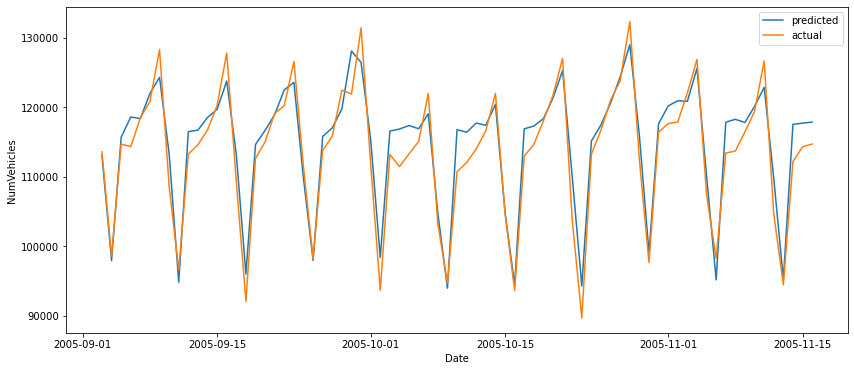

In [70]:
df_preds = pd.DataFrame(index=df.index[-len(preds):])
df_preds['NumVehicles']=preds
df_y=pd.DataFrame(index=df.index[-len(preds):])
df_y['NumVehicles']=y[-len(preds):]

fig, ax1 = plt.subplots(figsize=(14,6))
_=sns.lineplot(data=df_preds, x=df_preds.index, y='NumVehicles',ax=ax1)
_=sns.lineplot(data=df_y, x=df_y.index, y='NumVehicles',ax=ax1)
plt.legend(labels=["predicted","actual"])

# <mark> Permutation Importance 

In [71]:
from sklearn.inspection import permutation_importance

In [25]:
%%time
feature_names=hm.X_2.columns
result = permutation_importance(
    hm.model_2, hm.X_2.iloc[-hm.test_size:,:], y[-len(preds):], n_repeats=10, random_state=42, n_jobs=2, scoring=None)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

CPU times: user 15.1 ms, sys: 16 ms, total: 31.2 ms
Wall time: 111 ms


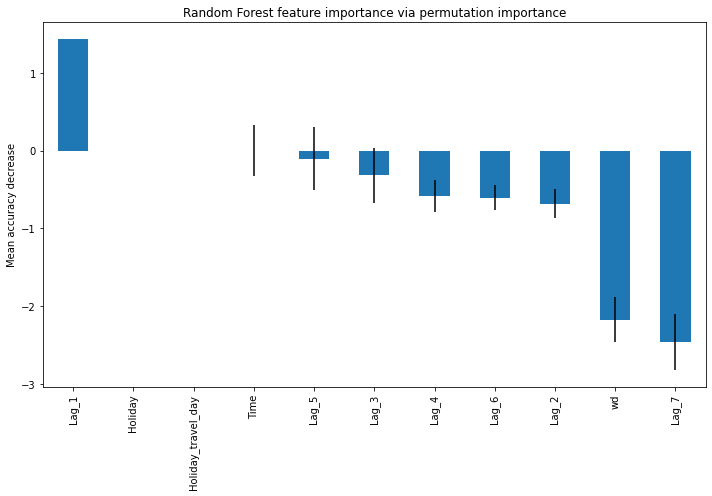

In [26]:
#plot em
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Random Forest feature importance via permutation importance")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Just some EDA to see if we can learn other stuff about the model

In [121]:
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
df['day']=[d.day for d in df.index]
df['week'] = [d.week for d in df.index]
#convert the index to datetime and get the days of the week and add to the dataframe
df['dayofweek'] = pd.to_datetime(df.index).day_name()
df.head()
years = df['year'].unique()


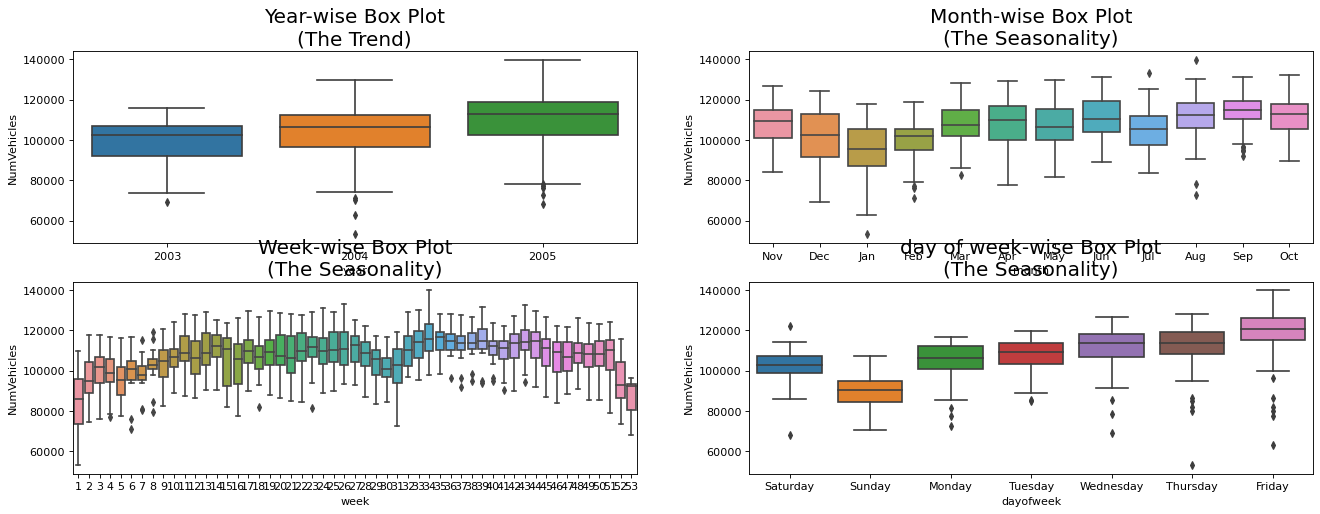

In [122]:
# Draw Plot
fig, axes = plt.subplots(2, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='NumVehicles', data=df, ax=axes[0,0])
sns.boxplot(x='month', y='NumVehicles', data=df, ax=axes[0,1])
sns.boxplot(x='week', y='NumVehicles', data=df, ax=axes[1,0])
sns.boxplot(x='dayofweek', y='NumVehicles', data=df, ax=axes[1,1])

# Set Title
axes[0,0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[0,1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1,0].set_title('Week-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1,1].set_title('day of week-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Let statsmodels seasonal_decompose do it all


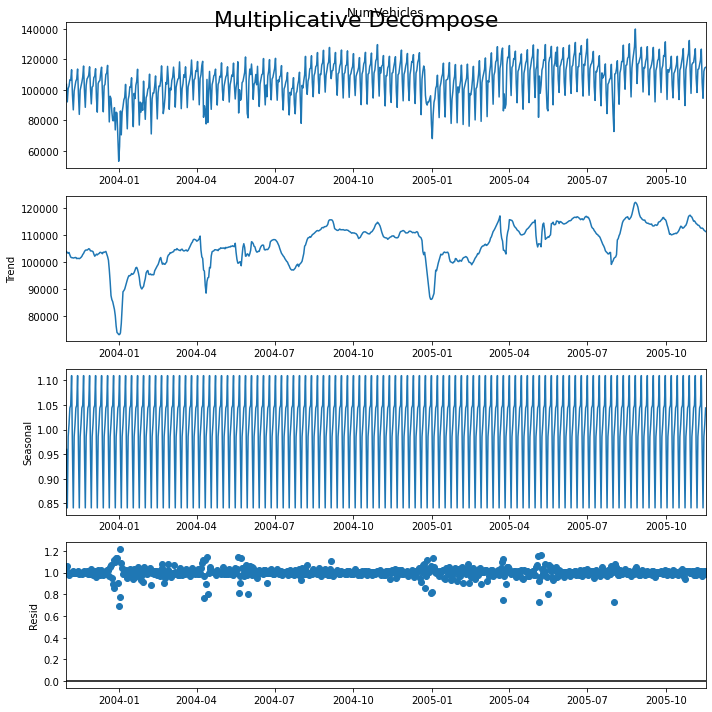

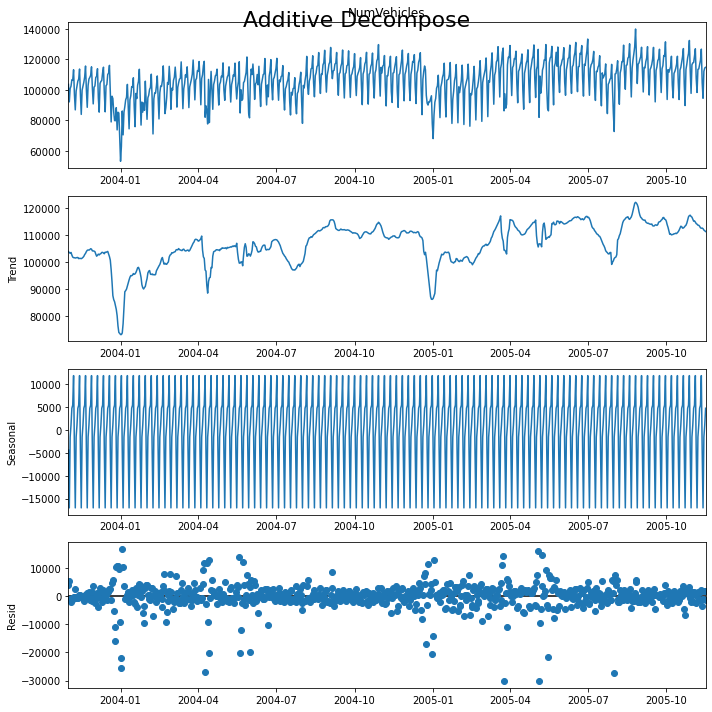

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['NumVehicles'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['NumVehicles'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()


In [124]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2003-11-01,0.959682,103809.928571,1.039262,103536.0
2003-11-02,0.840922,103510.341837,1.057521,92051.0
2003-11-03,0.985553,103210.755102,0.990909,100795.0
2003-11-04,1.010688,103528.285714,0.978183,102352.0
2003-11-05,1.043982,102566.857143,0.995247,106569.0
